
# MPC (1‑min) with Arbitrary Horizon **H** and 15‑min Settlement Blocks

This notebook extends the previous MPC controller so you can provide a **PV forecast of any length** (e.g., **H = 100 minutes**). The optimization will:

- run at **1‑minute resolution**,
- **pad the PV forecast** so the horizon ends on a 15‑minute boundary (per your request),
- compute **revenue per 15‑min block** (with your **14/15 boundary** rule and **12% shortfall**),
- treat the **day‑ahead schedule** as a **soft reference** per minute across the entire horizon,
- return the **first-minute setpoints** to dispatch now, plus detailed **minute‑plan** and **block‑level revenue** tables.

> **Padding rule (as requested):** if the given horizon ends in the middle of a 15‑min block, the missing tail minutes of that last block are padded using the **average PV** of the minutes already provided **in that same block**. If no minutes from that block were provided, we fall back to the **last measured PV minute** (if available), else **0**.

**What to prepare:**
- `revenue_function.py` (your existing module with window classification, 14/15 adjustment, and 12% penalty)
- `planning_test.csv` (or your real day‑ahead schedule with `ts_start` and the unit reference columns)


In [2]:

import math
import numpy as np
import pandas as pd
from datetime import timedelta
from typing import Optional

# Optimization
# If PuLP is not available, uncomment the next line (if your environment allows it)
# !pip install pulp
import pulp as pl

# Plotting
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")


In [3]:

# Uses your own revenue helper for window classification & special adjustments
from revenue_function import detect_time_window_for_aligned_blocks

PENALTY_RATE = 0.12          # same as your module
ADJUST_FACTOR_14_15 = 14.0/15.0  # applies to blocks starting at 06:00, 16:00, 18:00


In [4]:

# ===== Configuration =====
# Time
DT_MIN = 1.0                 # minute step
BLOCK_MIN = 15               # settlement block size (minutes)
DT_H = DT_MIN / 60.0         # hours per minute
KWH_PER_MW_MIN = 1000.0 * DT_H

# Contract / Plan defaults (used if schedule does not provide per-block values)
CONTRACT_MW = 45.0
CONTRACT_KWH_15MIN = CONTRACT_MW * (BLOCK_MIN/60.0) * 1000.0    # 11,250 kWh
EGAT_PLAN_FRAC = 0.60
EGAT_PLAN_KWH_15MIN = EGAT_PLAN_FRAC * CONTRACT_KWH_15MIN       # 6,750 kWh
FIT_RATE = 4.0                                                   # currency/kWh (default)

# BESS
BESS_P_CH_MAX = 10.0
BESS_P_DIS_MAX = 10.0
BESS_E_CAP = 10.0
BESS_E_INIT = 5.0
BESS_ETA_CH = 0.90
BESS_ETA_DIS = 0.90
BESS_COST_PER_KWH = 2.2     # optional cost for discharging to grid

# Turbines
TURBINES = ["T1", "T2", "T3"]
TURB_MAX_MW = {"T1": 12.0, "T2": 12.0, "T3": 12.0}
TURB_MIN_MW = {"T1":  7.0, "T2":  7.0, "T3":  7.0}
TURB_RAMP_MW_PER_MIN = {"T1": 3.0, "T2": 3.0, "T3": 3.0}
TURB_STARTUP_COST = {"T1": 500.0, "T2": 500.0, "T3": 500.0}
TURB_SHUTDOWN_COST = {"T1": 0.0,   "T2": 0.0,   "T3": 0.0}
TURB_VAR_COST_PER_KWH = 0.0  # set >0 if you want to charge turbine variable cost

# --- Shared Hydro Reservoir (for the 3 turbines) ---
HYDRO_CAP_MWH   = 135.0   # total usable reservoir capacity (MWh). Set to your plant value.
ETA_HYDRO_DIS   = 1.0     # discharge efficiency to grid-side energy (0<η<=1). Set if you have losses.
DEFAULT_INFLOW_MW = 0.0   # average water inflow in MW during the horizon (optional; can be a profile)

# Schedule tracking weights (soft reference)
W_TRACK_ON    = 5.0
W_TRACK_POWER = 0.4         # scaled like energy via KWH_PER_MW_MIN

# Export/import policy
ALLOW_IMPORT = False         # if False, e_meter_kwh >= 0

# Data path for schedule
DA_PATH = "planning_test.csv"  # change to your schedule
# ==========================

W_warm = {u: int(math.ceil(TURB_MIN_MW[u] / TURB_RAMP_MW_PER_MIN[u])) for u in TURBINES}



In [5]:

# Load 15-min schedule (reference & base per block); must include a 'ts_start' column
schedule_15m = pd.read_csv(DA_PATH, parse_dates=["ts_start"])
schedule_15m = schedule_15m.sort_values("ts_start").reset_index(drop=True)

# Fill defaults if needed
if "fit_rate" not in schedule_15m.columns:
    schedule_15m["fit_rate"] = FIT_RATE
if "contract_kwh" not in schedule_15m.columns:
    schedule_15m["contract_kwh"] = CONTRACT_KWH_15MIN
if "egat_plan_kwh" not in schedule_15m.columns:
    schedule_15m["egat_plan_kwh"] = EGAT_PLAN_KWH_15MIN
for u in TURBINES:
    if f"p_{u}_mw" not in schedule_15m.columns:
        schedule_15m[f"p_{u}_mw"] = 0.0
    if f"on_{u}" not in schedule_15m.columns:
        schedule_15m[f"on_{u}"] = 0

# NEW: ensure ETurbine_end_mwh is present and numeric (MWh cap per 15-min block)
if "ETurbine_end_mwh" not in schedule_15m.columns:
    # If you prefer: set a very large number or NaN when no cap is specified.
    schedule_15m["ETurbine_end_mwh"] = np.nan
else:
    schedule_15m["ETurbine_end_mwh"] = pd.to_numeric(schedule_15m["ETurbine_end_mwh"], errors="coerce")

schedule_15m.head(3)

,Unnamed: 0,ts_start,solar_kwh,e_turb_kwh,p_T1_mw,p_T2_mw,p_T3_mw,on_T1,on_T2,on_T3,e_bess_ch_kwh,e_bess_dis_kwh,E_bess_end_mwh,turbines_kwh,fit_rate,contract_kwh,egat_plan_kwh
0,0,2026-01-26 00:00:00,0.0,6750.0,8.0,12.0,7.0,1,1,1,0.0,0.0,5.0,6750.0,4.0,11250.0,6750.0
1,1,2026-01-26 00:15:00,0.0,6750.0,8.0,12.0,7.0,1,1,1,0.0,0.0,5.0,6750.0,4.0,11250.0,6750.0
2,2,2026-01-26 00:30:00,0.0,6750.0,12.0,8.0,7.0,1,1,1,0.0,0.0,5.0,6750.0,4.0,11250.0,6750.0


In [6]:
import pandas as pd

def base_and_adjust_for_block(ts_start, contract_kwh, egat_plan_kwh):
    """Return (base_kwh, adjusted_flag) using your revenue window helper."""
    win_id, adjusted = detect_time_window_for_aligned_blocks(pd.to_datetime(ts_start))
    if win_id == 1:
        base = float(contract_kwh)
    elif win_id == 2:
        base = float(egat_plan_kwh)
    else:  # window 3
        # If you keep a flag for Window 3 plan/contract selection, switch here; otherwise default to plan if present
        base = float(egat_plan_kwh) if not pd.isna(egat_plan_kwh) else float(contract_kwh)
    return base, bool(adjusted)

def pad_forecast_to_next_block(ts_block_start: pd.Timestamp,
                               pv_forecast_kwh: np.ndarray,
                               solar_meas_prev_min_kwh: Optional[float] = None) -> np.ndarray:
    """Pad last partial block by repeating the average PV of provided minutes in that block.
    If none provided for that block, use last measured PV minute; else 0.
    """
    H_in = int(pv_forecast_kwh.shape[0])
    if H_in == 0:
        return pv_forecast_kwh

    ts_end = ts_block_start + pd.Timedelta(minutes=H_in)  # end time (exclusive)
    # Already aligned to 15-min boundary?
    if (ts_end.minute % 15) == 0 and ts_end.second == 0:
        return pv_forecast_kwh

    next_boundary = ts_end.ceil("15min")
    pad_minutes = int((next_boundary - ts_end) / pd.Timedelta(minutes=1))

    # Identify minutes belonging to last (partial) block
    last_block_start = (ts_end - pd.Timedelta(seconds=1)).floor("15min")
    idxs = []
    for t in range(H_in):
        ts_t = ts_block_start + pd.Timedelta(minutes=t)
        if ts_t.floor("15min") == last_block_start:
            idxs.append(t)

    if len(idxs) > 0:
        avg_val = float(np.mean(pv_forecast_kwh[idxs]))
    else:
        avg_val = float(solar_meas_prev_min_kwh) if solar_meas_prev_min_kwh is not None else 0.0

    tail = np.full(pad_minutes, avg_val, dtype=float)
    return np.concatenate([pv_forecast_kwh, tail])


def partition_minutes_into_blocks(ts0: pd.Timestamp, H: int):
    """Return an ordered dict: {block_ts_start -> [minute_indices_in_that_block]}"""
    block_minutes = {}
    for t in range(H):
        ts_t = ts0 + pd.Timedelta(minutes=t)
        b_ts = ts_t.floor("15min")
        block_minutes.setdefault(b_ts, []).append(t)
    # Keep order by timestamp
    return dict(sorted(block_minutes.items(), key=lambda kv: kv[0]))


def get_block_financials(schedule_15m: pd.DataFrame, b_ts: pd.Timestamp):
    """Fetch per-block refs (fit, base, adjusted) and the reference schedule row."""
    match = schedule_15m.index[schedule_15m["ts_start"] == b_ts]
    if len(match) == 0:
        ref = schedule_15m.iloc[(schedule_15m["ts_start"] - b_ts).abs().argmin()]
    else:
        ref = schedule_15m.loc[match[0]]

    base_kwh, adjusted_flag = base_and_adjust_for_block(
        b_ts,
        ref.get("contract_kwh", CONTRACT_KWH_15MIN),
        ref.get("egat_plan_kwh", EGAT_PLAN_KWH_15MIN),
    )
    fit_rate = float(ref.get("fit_rate", FIT_RATE))
    return ref, base_kwh, adjusted_flag, fit_rate


def get_block_turbine_cap_kwh(schedule_15m: pd.DataFrame, b_ts: pd.Timestamp) -> float | None:
    """
    Return the turbine discharge cap for block b_ts in kWh (sum across all turbines),
    or None if no cap was provided.
    Input column ETurbine_end_mwh is MWh per 15-min block.
    """
    match = schedule_15m.index[schedule_15m["ts_start"] == b_ts]
    if len(match) == 0:
        ref = schedule_15m.iloc[(schedule_15m["ts_start"] - b_ts).abs().argmin()]
    else:
        ref = schedule_15m.loc[match[0]]

    val_mwh = ref.get("ETurbine_end_mwh", np.nan)
    if (val_mwh is None) or (pd.isna(val_mwh)):
        return None
    return float(val_mwh) * 1000.0  # convert MWh -> kWh

In [7]:

from datetime import datetime

def build_and_solve_mpc_multi_block(
    ts_block_start: pd.Timestamp,
    minutes_already_delivered_kwh: float,
    solar_meas_prev_min_kwh: float,
    solar_forecast_next_mins_kwh: np.ndarray,
    bess_soc_init_mwh: float,
    turb_last_p_mw: dict,
    turb_last_on: dict,
    schedule_15m: pd.DataFrame,
):
    """
    1-minute MPC over an arbitrary horizon H_in (e.g., 100 min), padded to end on a 15-min boundary.
    Settlement is computed per 15-min block along the horizon, using your FiT rules and 14/15 adjustments.
    """
    # 1) Pad PV so horizon ends exactly on a 15-min boundary
    pv = pad_forecast_to_next_block(ts_block_start, np.array(solar_forecast_next_mins_kwh, dtype=float), solar_meas_prev_min_kwh)
    H = int(pv.shape[0])
    if H == 0:
        return {
            "first_minute": None,
            "plan_table": pd.DataFrame(),
            "block_table": pd.DataFrame(),
            "solver_status": "NO_HORIZON",
            "objective_value": 0.0,
        }

    MINS = range(H)
    block_minutes = partition_minutes_into_blocks(ts_block_start, H)

    # 2) Build optimization model
    prob = pl.LpProblem("MPC_1min_MultiBlock", pl.LpMaximize)

    # --- Variables per minute ---
    # BESS power & binaries
    p_bess_ch = pl.LpVariable.dicts("p_bess_ch_mw", MINS, lowBound=0)
    p_bess_dis= pl.LpVariable.dicts("p_bess_dis_mw", MINS, lowBound=0)
    u_bess_ch = pl.LpVariable.dicts("u_bess_ch", MINS, lowBound=0, upBound=1, cat="Binary")
    u_bess_dis= pl.LpVariable.dicts("u_bess_dis", MINS, lowBound=0, upBound=1, cat="Binary")

    # BESS energy (kWh) and SoC (MWh)
    e_bess_ch = pl.LpVariable.dicts("e_bess_ch_kwh", MINS, lowBound=0)
    e_bess_dis= pl.LpVariable.dicts("e_bess_dis_kwh", MINS, lowBound=0)
    E_bess    = pl.LpVariable.dicts("E_bess_mwh", range(H+1), lowBound=0, upBound=BESS_E_CAP)

    # Turbines
    p = {u: pl.LpVariable.dicts(f"p_{u}_mw", MINS, lowBound=0) for u in TURBINES}
    y = {u: pl.LpVariable.dicts(f"on_{u}", MINS, lowBound=0, upBound=1, cat="Binary") for u in TURBINES}
    z_start = {u: pl.LpVariable.dicts(f"z_start_{u}", MINS, lowBound=0, upBound=1, cat="Binary") for u in TURBINES}
    z_stop  = {u: pl.LpVariable.dicts(f"z_stop_{u}",  MINS, lowBound=0, upBound=1, cat="Binary") for u in TURBINES}

    # Meter energy
    e_meter = pl.LpVariable.dicts("e_meter_kwh", MINS, lowBound=0 if not ALLOW_IMPORT else None)

    # 3) Initial conditions
    prob += E_bess[0] == bess_soc_init_mwh, "BESS_init"

    # 4) Start/stop logic for t=0 vs last minute
    t0 = 0
    for u in TURBINES:
        prob += z_start[u][t0] >= y[u][t0] - turb_last_on[u]
        prob += z_start[u][t0] <= y[u][t0]
        prob += z_start[u][t0] <= 1 - turb_last_on[u]

        prob += z_stop[u][t0]  >= turb_last_on[u] - y[u][t0]
        prob += z_stop[u][t0]  <= turb_last_on[u]
        prob += z_stop[u][t0]  <= 1 - y[u][t0]

    for t in range(1, H):
        for u in TURBINES:
            prob += z_start[u][t] >= y[u][t] - y[u][t-1]
            prob += z_start[u][t] <= y[u][t]
            prob += z_start[u][t] <= 1 - y[u][t-1]

            prob += z_stop[u][t]  >= y[u][t-1] - y[u][t]
            prob += z_stop[u][t]  <= y[u][t-1]
            prob += z_stop[u][t]  <= 1 - y[u][t]

    # 5) BESS limits & SoC dynamics
    for t in MINS:
        prob += p_bess_ch[t] <= BESS_P_CH_MAX * u_bess_ch[t]
        prob += p_bess_dis[t] <= BESS_P_DIS_MAX * u_bess_dis[t]
        prob += u_bess_ch[t] + u_bess_dis[t] <= 1
        prob += e_bess_ch[t] == p_bess_ch[t] * KWH_PER_MW_MIN
        prob += e_bess_dis[t] == p_bess_dis[t] * KWH_PER_MW_MIN
        prob += E_bess[t+1] == E_bess[t] + (p_bess_ch[t] * DT_H * BESS_ETA_CH) - (p_bess_dis[t] * DT_H / BESS_ETA_DIS)

    # 6) Turbine bounds & ramps
    for t in MINS:
        for u in TURBINES:
            # Upper bound (unchanged)
            prob += p[u][t] <= TURB_MAX_MW[u] * y[u][t]
    
            # Sum starts in the last W_warm minutes (clip range to 0..t)
            if W_warm[u] > 0:
                relax_sum = pl.lpSum(
                    z_start[u][k] for k in range(max(0, t - W_warm[u] + 1), t + 1)
                )
            else:
                relax_sum = 0
    
            # Multi-minute warm-up: relax min during the warm-up window
            prob += p[u][t] >= TURB_MIN_MW[u] * y[u][t] - TURB_MIN_MW[u] * relax_sum
    # for t in MINS:
    #     for u in TURBINES:
    #         prob += p[u][t] <= TURB_MAX_MW[u] * y[u][t]
    #         prob += p[u][t] >= TURB_MIN_MW[u] * y[u][t] - TURB_MIN_MW[u] * z_start[u][t]

    for u in TURBINES:
        ramp = TURB_RAMP_MW_PER_MIN[u]
        prob += p[u][0] - turb_last_p_mw[u] <= ramp
        prob += turb_last_p_mw[u] - p[u][0] <= ramp
    for t in range(1, H):
        for u in TURBINES:
            ramp = TURB_RAMP_MW_PER_MIN[u]
            prob += p[u][t] - p[u][t-1] <= ramp
            prob += p[u][t-1] - p[u][t] <= ramp

    # 7) Meter balance (per minute)
    for t in MINS:
        solar_kwh = float(pv[t])
        e_turb_kwh = pl.lpSum(p[u][t] * KWH_PER_MW_MIN for u in TURBINES)
        prob += e_meter[t] == solar_kwh + e_turb_kwh + e_bess_dis[t] - e_bess_ch[t]

    # 8) Soft tracking to day-ahead schedule (per minute, per unit)
    track_terms = []
    for t in MINS:
        ts_t = ts_block_start + pd.Timedelta(minutes=t)
        b_ts = ts_t.floor("15min")
        ref, _, _, _ = get_block_financials(schedule_15m, b_ts)
        for u in TURBINES:
            p_ref = float(ref.get(f"p_{u}_mw", 0.0))
            y_ref = int(ref.get(f"on_{u}", 0))

            devP_pos = pl.LpVariable(f"devP_pos_{u}_{t}", lowBound=0)
            devP_neg = pl.LpVariable(f"devP_neg_{u}_{t}", lowBound=0)
            prob += p[u][t] - p_ref == devP_pos - devP_neg
            track_terms.append(W_TRACK_POWER * (devP_pos + devP_neg) * KWH_PER_MW_MIN)

            devY_pos = pl.LpVariable(f"devY_pos_{u}_{t}", lowBound=0)
            devY_neg = pl.LpVariable(f"devY_neg_{u}_{t}", lowBound=0)
            prob += y[u][t] - y_ref == devY_pos - devY_neg
            track_terms.append(W_TRACK_ON * (devY_pos + devY_neg))

    track_penalty = pl.lpSum(track_terms)

    # 9) Per-block payoff variables & revenue
    revenue_terms = []
    payable_b = {}
    shortfall_b = {}

    for i_b, (b_ts, idxs) in enumerate(block_minutes.items()):
        ref, base_kwh, adjusted_flag, fit_rate = get_block_financials(schedule_15m, b_ts)
        e_sum_future_b = pl.lpSum(e_meter[t] for t in idxs)
        already = minutes_already_delivered_kwh if b_ts == ts_block_start else 0.0
        e_block_total = already + e_sum_future_b
        e_use_b = e_block_total * (ADJUST_FACTOR_14_15 if adjusted_flag else 1.0)

        payable_b[b_ts]   = pl.LpVariable(f"payable_{b_ts.strftime('%Y%m%d_%H%M')}",   lowBound=0)
        shortfall_b[b_ts] = pl.LpVariable(f"shortfall_{b_ts.strftime('%Y%m%d_%H%M')}", lowBound=0)

        prob += payable_b[b_ts]   <= e_use_b
        prob += payable_b[b_ts]   <= base_kwh
        prob += shortfall_b[b_ts] >= base_kwh - e_use_b

        revenue_terms.append( fit_rate * (payable_b[b_ts] - PENALTY_RATE * shortfall_b[b_ts]) )

        # --- NEW: per-block turbine discharge cap (across all turbines) ---
        cap_kwh = get_block_turbine_cap_kwh(schedule_15m, b_ts)
        if cap_kwh is not None:
            # Sum turbine energy within this block (kWh)
            e_turb_block = pl.lpSum(
                pl.lpSum(p[u][t] * KWH_PER_MW_MIN for u in TURBINES)
                for t in idxs
            )
            prob += e_turb_block <= cap_kwh, f"TurbineCap_{b_ts.strftime('%Y%m%d_%H%M')}"

    var_costs = (
        TURB_VAR_COST_PER_KWH * pl.lpSum(p[u][t] * KWH_PER_MW_MIN for u in TURBINES for t in MINS)
        + BESS_COST_PER_KWH * pl.lpSum(e_bess_dis[t] for t in MINS)
    )

    start_stop_cost = pl.lpSum(TURB_STARTUP_COST[u] * z_start[u][t] + TURB_SHUTDOWN_COST[u] * z_stop[u][t]
                               for u in TURBINES for t in MINS)

    # 10) Objective
    prob += pl.lpSum(revenue_terms) - var_costs - track_penalty - start_stop_cost

    # 11) Solve
    _ = prob.solve(pl.PULP_CBC_CMD(msg=False, warmStart=True))
    status = pl.LpStatus[prob.status]
    objv = float(pl.value(prob.objective)) if prob.status == 1 else float('nan')

    # 12) Extract per-minute plan
    rows = []
    for t in MINS:
        row = {
            "minute_index": t,
            "ts": ts_block_start + pd.Timedelta(minutes=t),
            "e_meter_kwh": pl.value(e_meter[t]),
            "e_bess_ch_kwh": pl.value(e_bess_ch[t]),
            "e_bess_dis_kwh": pl.value(e_bess_dis[t]),
            "E_bess_mwh": pl.value(E_bess[t+1]),
        }
        for u in TURBINES:
            row[f"p_{u}_mw"] = pl.value(p[u][t])
            row[f"on_{u}"] = int(pl.value(y[u][t]) > 0.5)
            row[f"z_start_{u}"] = int(pl.value(z_start[u][t]) > 0.5)
            row[f"z_stop_{u}"]  = int(pl.value(z_stop[u][t])  > 0.5)
        rows.append(row)
    plan_df = pd.DataFrame(rows)

    # 13) First-minute actions
    first = {
        "p_bess_ch_mw": float(pl.value(p_bess_ch[0])) if H > 0 else 0.0,
        "p_bess_dis_mw": float(pl.value(p_bess_dis[0])) if H > 0 else 0.0,
    }
    for u in TURBINES:
        first[f"p_{u}_mw"] = float(pl.value(p[u][0])) if H > 0 else 0.0
        first[f"on_{u}"]   = int(pl.value(y[u][0]) > 0.5) if H > 0 else turb_last_on[u]

    # 14) Per-block summary (reconstruct e_use and revenue numerically)
    b_rows = []
    for b_ts, idxs in block_minutes.items():
        ref, base_kwh, adjusted_flag, fit_rate = get_block_financials(schedule_15m, b_ts)
        # Sum realized minute values
        e_sum = float(plan_df.loc[idxs, "e_meter_kwh"].sum()) if len(plan_df) > 0 else 0.0
        already = float(minutes_already_delivered_kwh) if b_ts == ts_block_start else 0.0
        e_block_total_val = already + e_sum
        e_use_val = e_block_total_val * (ADJUST_FACTOR_14_15 if adjusted_flag else 1.0)
        pay_val = float(pl.value(payable_b[b_ts]))
        short_val = float(pl.value(shortfall_b[b_ts]))
        rev_val = fit_rate * (pay_val - PENALTY_RATE * short_val)

        b_rows.append({
            "ts_start": b_ts,
            "fit_rate": fit_rate,
            "base_kwh": base_kwh,
            "adjusted_14_15": int(adjusted_flag),
            "e_block_total_kwh": e_block_total_val,
            "e_use_kwh": e_use_val,
            "payable_kwh": pay_val,
            "shortfall_kwh": short_val,
            "revenue_currency": rev_val,
        })

    block_df = pd.DataFrame(b_rows).sort_values("ts_start").reset_index(drop=True)

    return {
        "first_minute": first,
        "plan_table": plan_df,
        "block_table": block_df,
        "solver_status": status,
        "objective_value": objv,
    }


In [8]:

# Simple stateful skeleton you can call every minute
state = {
    "bess_soc_mwh": BESS_E_INIT,
    "t_last_p_mw": {u: 0.0 for u in TURBINES},
    "t_last_on":  {u: 0   for u in TURBINES},
    "block_ts": None,
    "e_block_cum_kwh": 0.0,   # cumulative energy delivered so far in current block
}

def run_one_minute_anyH(ts_now: pd.Timestamp,
                        solar_meas_prev_min_kwh: float,
                        solar_forecast_next_mins_kwh: np.ndarray,
                        schedule_15m: pd.DataFrame,
                        bess_soc_current_mwh: Optional[float] = None):
    # Identify the current block start
    ts_block = pd.to_datetime(ts_now).floor("15min")

    # Initialize or roll block counters if new block
    if state["block_ts"] is None or ts_block != state["block_ts"]:
        state["block_ts"] = ts_block
        state["e_block_cum_kwh"] = 0.0

    # Use provided SoC if given (e.g., telemetry), else keep state
    if bess_soc_current_mwh is not None:
        state["bess_soc_mwh"] = float(bess_soc_current_mwh)

    out = build_and_solve_mpc_multi_block(
        ts_block_start=ts_block,
        minutes_already_delivered_kwh=state["e_block_cum_kwh"],
        solar_meas_prev_min_kwh=solar_meas_prev_min_kwh,
        solar_forecast_next_mins_kwh=np.array(solar_forecast_next_mins_kwh, dtype=float),
        bess_soc_init_mwh=state["bess_soc_mwh"],
        turb_last_p_mw=state["t_last_p_mw"],
        turb_last_on=state["t_last_on"],
        schedule_15m=schedule_15m,
    )

    # Apply (here: update state only)
    plan_df = out["plan_table"]
    if len(plan_df) > 0:
        # Update SoC to end-of-first-minute
        state["bess_soc_mwh"] = float(plan_df.loc[0, "E_bess_mwh"]) if not math.isnan(plan_df.loc[0, "E_bess_mwh"]) else state["bess_soc_mwh"]
        # Accumulate delivered energy for current block by the first minute we will actually execute
        state["e_block_cum_kwh"] += float(plan_df.loc[0, "e_meter_kwh"]) if not math.isnan(plan_df.loc[0, "e_meter_kwh"]) else 0.0
        # Update last turbine commands
        for u in TURBINES:
            state["t_last_p_mw"][u] = float(plan_df.loc[0, f"p_{u}_mw"]) if not math.isnan(plan_df.loc[0, f"p_{u}_mw"]) else state["t_last_p_mw"][u]
            state["t_last_on"][u]  = int(plan_df.loc[0, f"on_{u}"]) if not math.isnan(plan_df.loc[0, f"on_{u}"]) else state["t_last_on"][u]

    return out


C:\Users\Jarup\anaconda3\Lib\site-packages\pulp\apis\coin_api.py:112: UserWarning: When using CBC on Windows, warmStart requires keepFiles=True.
  warnings.warn(


Solver status: Optimal
Objective value: 78347.98626066658
First-minute setpoints: {'p_bess_ch_mw': 0.0, 'p_bess_dis_mw': 0.0, 'p_T1_mw': 3.0, 'on_T1': 1, 'p_T2_mw': 3.0, 'on_T2': 1, 'p_T3_mw': 3.0, 'on_T3': 1}


,minute_index,ts,e_meter_kwh,e_bess_ch_kwh,e_bess_dis_kwh,E_bess_mwh,p_T1_mw,on_T1,z_start_T1,z_stop_T1,p_T2_mw,on_T2,z_start_T2,z_stop_T2,p_T3_mw,on_T3,z_start_T3,z_stop_T3
0,0,2026-01-26 06:30:00,170.68873,0.0,0.0,5.0,3.0,1,1,0,3.000000,1,1,0,3.0,1,1,0
1,1,2026-01-26 06:31:00,320.68873,0.0,0.0,5.0,6.0,1,0,0,6.000000,1,0,0,6.0,1,0,0
2,2,2026-01-26 06:32:00,404.02206,0.0,0.0,5.0,7.0,1,0,0,9.000000,1,0,0,7.0,1,0,0
3,3,2026-01-26 06:33:00,449.99999,0.0,0.0,5.0,7.0,1,0,0,11.758676,1,0,0,7.0,1,0,0
4,4,2026-01-26 06:34:00,449.99999,0.0,0.0,5.0,7.0,1,0,0,11.758676,1,0,0,7.0,1,0,0
5,5,2026-01-26 06:35:00,449.99999,0.0,0.0,5.0,7.0,1,0,0,11.758676,1,0,0,7.0,1,0,0
6,6,2026-01-26 06:36:00,499.99999,0.0,0.0,5.0,10.0,1,0,0,11.758676,1,0,0,7.0,1,0,0
7,7,2026-01-26 06:37:00,449.99999,0.0,0.0,5.0,7.0,1,0,0,11.758676,1,0,0,7.0,1,0,0
8,8,2026-01-26 06:38:00,499.99999,0.0,0.0,5.0,10.0,1,0,0,11.758676,1,0,0,7.0,1,0,0
9,9,2026-01-26 06:39:00,533.33333,0.0,0.0,5.0,12.0,1,0,0,11.758676,1,0,0,7.0,1,0,0


,ts_start,fit_rate,base_kwh,adjusted_14_15,e_block_total_kwh,e_use_kwh,payable_kwh,shortfall_kwh,revenue_currency
0,2026-01-26 06:30:00,4.0,6750.0,0,6749.99999,6749.99999,6750.0,0.0,27000.0
1,2026-01-26 06:45:00,4.0,6750.0,0,6783.33333,6783.33333,6750.0,0.0,27000.0
2,2026-01-26 07:00:00,4.0,6750.0,0,8500.00005,8500.00005,6750.0,0.0,27000.0


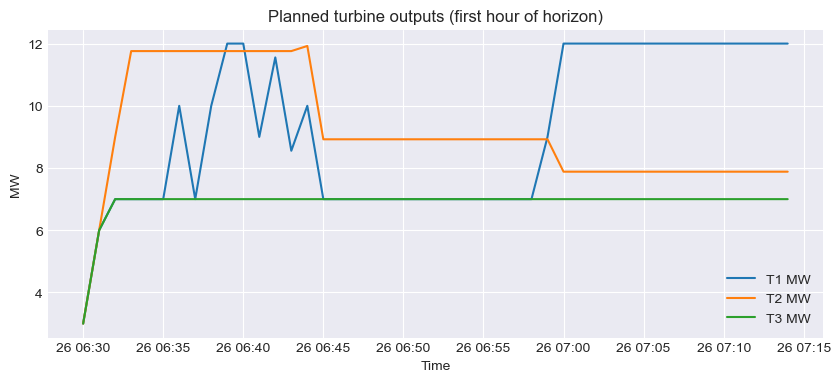

In [9]:

# --- Demo ---
# Build a 100-minute forecast using schedule PV (block solar_kwh / 15 per minute)

H_demo = 44
if "solar_kwh" in schedule_15m.columns and (schedule_15m["solar_kwh"] > 0).any():
    start_idx = schedule_15m.index[schedule_15m["solar_kwh"] > 0][0]
else:
    start_idx = 0
start_block_ts = pd.to_datetime(schedule_15m.loc[start_idx, "ts_start"]).floor("15min")

pv_1min = []
for t in range(H_demo):
    ts_t = start_block_ts + pd.Timedelta(minutes=t)
    b_ts = ts_t.floor("15min")
    match = schedule_15m.index[schedule_15m["ts_start"] == b_ts]
    if len(match) == 0:
        pv_1min.append(0.0)
    else:
        E15 = float(schedule_15m.loc[match[0], "solar_kwh"]) if "solar_kwh" in schedule_15m.columns else 0.0
        pv_1min.append(E15 / 15.0)

pv_1min = np.array(pv_1min, dtype=float)

# Reset runtime state
state.update({
    "bess_soc_mwh": BESS_E_INIT,
    "t_last_p_mw": {u: 0.0 for u in TURBINES},
    "t_last_on":  {u: 0   for u in TURBINES},
    "block_ts": None,
    "e_block_cum_kwh": 0.0,
})

out_demo = run_one_minute_anyH(
    ts_now=start_block_ts,
    solar_meas_prev_min_kwh=0.0,
    solar_forecast_next_mins_kwh=pv_1min,
    schedule_15m=schedule_15m,
)

print("Solver status:", out_demo["solver_status"])
print("Objective value:", out_demo["objective_value"]) 
print("First-minute setpoints:", out_demo["first_minute"]) 

# Show first 10 minutes of the plan and the per-block revenue summary
from IPython.display import display
if isinstance(out_demo.get("plan_table"), pd.DataFrame):
    display(out_demo["plan_table"].head(10))
if isinstance(out_demo.get("block_table"), pd.DataFrame):
    display(out_demo["block_table"]) 

# Quick plot of 1st-hour turbine plan (first 60 min if available)
plan = out_demo["plan_table"]
if len(plan) > 0:
    upto = min(60, len(plan))
    fig, ax = plt.subplots(figsize=(10,4))
    for u in TURBINES:
        ax.plot(plan["ts"].iloc[:upto], plan[f"p_{u}_mw"].iloc[:upto], label=f"{u} MW")
    ax.set_title("Planned turbine outputs (first hour of horizon)")
    ax.set_xlabel("Time")
    ax.set_ylabel("MW")
    ax.legend()
    plt.show()



## Integration Notes

- **Call every minute** with your live inputs:
  - `ts_now` = current timestamp,
  - `solar_meas_prev_min_kwh` = last minute PV from SCADA,
  - `solar_forecast_next_mins_kwh` = any-length PV forecast (e.g., 100 mins). The solver will **pad to the next 15-min boundary** per your instruction.
- The solver computes **revenue per 15‑minute block** across the horizon (with your **14/15** adjustments and **12%** penalty). The **first block** also adds the already delivered energy in this block.
- It returns:
  - `first_minute`: **dispatch commands** for the next minute (BESS charge/discharge MW and each turbine's MW & on/off),
  - `plan_table`: per-minute plan across the horizon,
  - `block_table`: one row per settlement block with payable/shortfall and revenue.

### Customization points
- **Contract/EGAT plan**: if you store block-specific values in your schedule, the model uses them; otherwise it uses the defaults in the config cell.
- **Time-varying FiT**: put `fit_rate` per `ts_start` in the schedule; it will be picked up per block.
- **Tracking aggression**: increase `W_TRACK_POWER`/`W_TRACK_ON` to adhere more to day-ahead instructions.
- **BESS/Turbine parameters**: replace min/max, ramps, efficiencies, costs with plant data.
- **Import**: set `ALLOW_IMPORT=True` if import is allowed (and add import price if needed).

If you want, I can pre-fill this with your real unit limits and tariff tables and send back a plant-ready version.
